## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json', 'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

#### Analyze Columns to rename appropriately

In [5]:
df.iloc[:,0:5].head()

,_index,_type,_id,_score,_source.tags
0,complaint-public-v2,complaint,3211475,0.0,None
1,complaint-public-v2,complaint,3229299,0.0,Servicemember
2,complaint-public-v2,complaint,3199379,0.0,None
3,complaint-public-v2,complaint,2673060,0.0,None
4,complaint-public-v2,complaint,3203545,0.0,None


In [6]:
df.iloc[:,5:10].head()

,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state
0,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA
1,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA
2,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX
3,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI
4,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY


In [7]:
df.iloc[:,10:15].head()

,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via
0,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web
1,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web
2,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web
3,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web
4,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral


In [8]:
df['_source.consumer_disputed'].value_counts()

_source.consumer_disputed
N/A    35683
No     33107
Yes     9523
Name: count, dtype: int64

In [9]:
df.iloc[:,15:20].head()

,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened
0,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,
1,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...
2,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,
4,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,


In [10]:
df.iloc[:,20:].head()

,_source.sub_issue,_source.consumer_consent_provided
0,Debt is not yours,Consent not provided
1,Didn't receive enough information to verify debt,Consent provided
2,Problem with rewards from credit card,Consent provided
3,None,Consent not provided
4,Charged too much interest,N/A


In [11]:
#Assign new column names
df1 = df.rename(columns = {'_index': 'index', '_type': 'ticket_type', '_id': 'id', 
                '_score': 'score', '_source.tags': 'tags', '_source.zip_code': 'zip_code',
                '_source.complaint_id': 'complaint_id', '_source.issue': 'issue', '_source.date_received': 'complaint_date',
                '_source.state': 'state', '_source.consumer_disputed': 'is_consumer_disputed', '_source.product': 'product',
                '_source.company_response': 'company_response', '_source.company': 'company', 
                '_source.submitted_via': 'submitted_via', '_source.date_sent_to_company': 'date_sent_to_company',
                '_source.company_public_response': '_source.company_public_response', '_source.sub_product': 'sub_product',
                '_source.timely': 'timely', '_source.complaint_what_happened': 'complaint_description', 
                '_source.sub_issue': 'sub_issue', '_source.consumer_consent_provided': 'is_consumer_consent_provided'
                })

In [12]:
df1.columns

Index(['index', 'ticket_type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'complaint_date', 'state',
       'is_consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company',
       '_source.company_public_response', 'sub_product', 'timely',
       'complaint_description', 'sub_issue', 'is_consumer_consent_provided'],
      dtype='object')

In [13]:
#Assign nan in place of blanks in the complaints column
df1['complaint_description'] = df1['complaint_description'].replace('', np.nan)


In [14]:
df1['complaint_description'].isna().sum()

57241

In [15]:
#Remove all rows where complaints column is nan
df2 = df1.dropna(subset=['complaint_description'])

In [16]:
df2['complaint_description'].isna().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = text.strip()  # remove leading and trailing spaces
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove words with 1 or 2 characters
    return text

In [18]:
df2['complaint_description'] = df2['complaint_description'].apply(clean_text)

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/2031822897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['complaint_description'] = df2['complaint_description'].apply(clean_text)


In [19]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [20]:
# Use nlp.pipe for batch processing
df2['complaints_lemmatized'] = list(nlp.pipe(df2['complaint_description'].dropna()))
df2['complaints_lemmatized'] = df2['complaints_lemmatized'].apply(lambda doc: ' '.join([token.lemma_ for token in doc]))

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/826681342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['complaints_lemmatized'] = list(nlp.pipe(df2['complaint_description'].dropna()))
/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/826681342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['complaints_lemmatized'] = df2['complaints_lemmatized'].apply(lambda doc: ' '.join([token.lemma_ for token in doc]))


In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df2[["complaint_description", "complaints_lemmatized"]]

In [22]:
df_clean.head()

,complaint_description,complaints_lemmatized
1,good morning name xxxx xxxx and appreciate ...,good morning name xxxx xxxx and apprecia...
2,upgraded xxxx xxxx card xxxx and was told ...,upgrade xxxx xxxx card xxxx and be tell ...
10,chase card was reported xxxx however fraudule...,chase card be report xxxx however fraudulent...
11,xxxx while trying book xxxx xxxx ticket ca...,xxxx while try book xxxx xxxx ticket c...
14,grand son give check for deposit into ch...,grand son give check for deposit into...


In [24]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  doc = nlp(text)
  pos_tags = [(token.text, token.pos_) for token in doc]
  return pos_tags

df_clean['complaint_POS'] = df_clean['complaints_lemmatized'].apply(pos_tag)


/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/2662783195.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['complaint_POS'] = df_clean['complaints_lemmatized'].apply(pos_tag)


In [25]:
df_clean['complaint_POS'].value_counts()

complaint_POS
[(chase, NOUN), (have, AUX), (violate, VERB), (usc, NOUN), (  , SPACE), (continue, VERB), (collection, NOUN), (activity, NOUN), (after, ADP), (  , SPACE), (cease, VERB), (and, CCONJ), (desist, VERB), (and, CCONJ), (usc, ADJ), (  , SPACE), (fail, ADJ), (  , SPACE), (report, NOUN), (complete, ADJ), (and, CCONJ), (accurate, ADJ), (information, NOUN), (  , SPACE), (credit, NOUN), (reporting, NOUN), (bureau, NOUN)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [26]:
# df_clean["complaint_POS_removed"] =  df_clean[df_clean['complaint_POS']] #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['complaints_lemmatized'].apply(
    lambda x: ' '.join([word for word, tag in pos_tag(x) if tag == "NOUN"])
)

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/2991147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["complaint_POS_removed"] = df_clean['complaints_lemmatized'].apply(


In [27]:
df_clean.drop(columns=['complaint_POS'], inplace=True)

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/1215020420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['complaint_POS'], inplace=True)


In [28]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_description,complaints_lemmatized,complaint_POS_removed
1,good morning name xxxx xxxx and appreciate ...,good morning name xxxx xxxx and apprecia...,morning name chase ask debt verification state...
2,upgraded xxxx xxxx card xxxx and was told ...,upgrade xxxx xxxx card xxxx and be tell ...,card agent upgrade anniversary date agent info...
10,chase card was reported xxxx however fraudule...,chase card be report xxxx however fraudulent...,chase card report application identity consent...
11,xxxx while trying book xxxx xxxx ticket ca...,xxxx while try book xxxx xxxx ticket c...,book ticket offer ticket reward card informati...
14,grand son give check for deposit into ch...,grand son give check for deposit into...,son check deposit chase account fund account m...
...,...,...,...
78303,after being chase card customer for well over...,after be chase card customer for well over ...,chase card customer decade solicitation credit...
78309,wednesday xxxxxxxx called chas xxxx xxxx vi...,wednesday xxxxxxxx call chas xxxx xxxx v...,credit card provider claim purchase protection...
78310,not familiar with xxxx pay and did not under...,not familiar with xxxx pay and do not under...,pay risk consumer chase year banking deal merc...
78311,have had flawless credit for yrs ive had chas...,have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




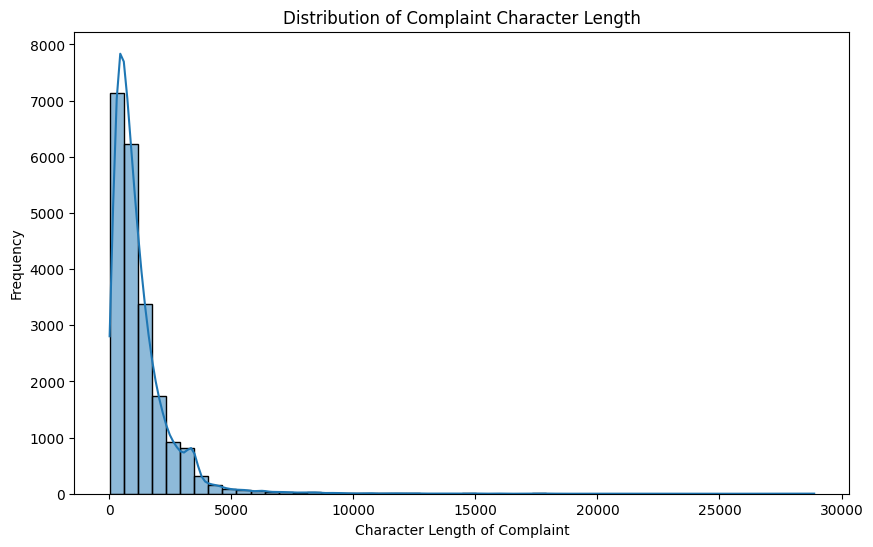

In [29]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaints_lemmatized'].str.len(), bins=50, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length of Complaint')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

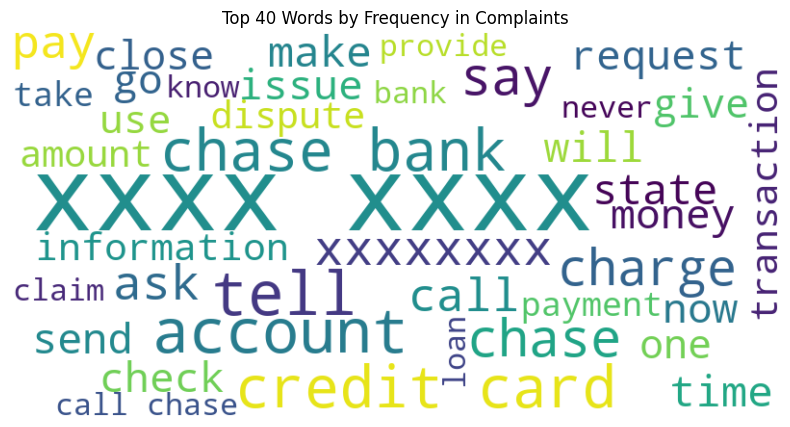

In [30]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
text = ' '.join(df_clean['complaints_lemmatized'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=40).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency in Complaints')
plt.show()

In [31]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/1697981806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
# df_clean
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english')
X = vectorizer.fit_transform(df_clean['Complaint_clean'])
unigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
unigram_freq = unigram_freq.sum().reset_index()
unigram_freq.columns = ['word', 'frequency']
unigram_freq = unigram_freq.sort_values(by='frequency', ascending=False).head(30)
unigram_freq.reset_index(drop=True, inplace=True)
unigram_freq

,word,frequency
0,chase,63973
1,account,45247
2,credit,33700
3,card,30233
4,bank,21721
5,payment,21160
6,time,15978
7,charge,14910
8,day,13185
9,money,11936


In [33]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigram Frequencies:")
print(unigram_freq.head(10))

Top 10 Unigram Frequencies:
      word  frequency
0    chase      63973
1  account      45247
2   credit      33700
3     card      30233
4     bank      21721
5  payment      21160
6     time      15978
7   charge      14910
8      day      13185
9    money      11936


In [34]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigram = vectorizer_bigram.fit_transform(df_clean['Complaint_clean'])
bigram_freq = pd.DataFrame(X_bigram.toarray(), columns=vectorizer_bigram.get_feature_names_out())
bigram_freq = bigram_freq.sum().reset_index()
bigram_freq.columns = ['word', 'frequency']
bigram_freq = bigram_freq.sort_values(by='frequency', ascending=False).head(30)
bigram_freq.reset_index(drop=True, inplace=True)
bigram_freq

,word,frequency
0,credit card,12859
1,credit report,3947
2,chase bank,3788
3,chase credit,3442
4,account chase,3334
5,customer service,3061
6,chase account,2850
7,account account,2360
8,bank account,2301
9,check account,2266


In [35]:
#Print the top 10 words in the bigram frequency
print("Top 10 Bigram Frequencies:")
print(bigram_freq.head(10))

Top 10 Bigram Frequencies:
               word  frequency
0       credit card      12859
1     credit report       3947
2        chase bank       3788
3      chase credit       3442
4     account chase       3334
5  customer service       3061
6     chase account       2850
7   account account       2360
8      bank account       2301
9     check account       2266


In [36]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english')


In [37]:
X_trigram = vectorizer_trigram.fit_transform(df_clean['Complaint_clean'].dropna())


In [38]:
trigram_counts = X_trigram.sum(axis=0)


In [39]:
trigram_freq = dict(zip(vectorizer_trigram.get_feature_names_out(), trigram_counts.A1))


In [40]:
df_trigram_freq = pd.DataFrame(trigram_freq.items(), columns=['word-Trigram', 'frequency'])

In [41]:
triram_freq = df_trigram_freq.sort_values(by='frequency', ascending=False).head(30)
triram_freq.reset_index(drop=True, inplace=True)
triram_freq

,word-Trigram,frequency
0,chase credit card,2343
1,credit card account,1107
2,credit card company,998
3,credit card chase,824
4,chase customer service,649
5,credit card credit,527
6,inquiry credit report,518
7,charge credit card,424
8,account credit card,422
9,chase check account,420


In [42]:
#Print the top 10 words in the trigram frequency
print("Top 10 Trigram Frequencies:")
print(triram_freq.head(10))

Top 10 Trigram Frequencies:
             word-Trigram  frequency
0       chase credit card       2343
1     credit card account       1107
2     credit card company        998
3       credit card chase        824
4  chase customer service        649
5      credit card credit        527
6   inquiry credit report        518
7      charge credit card        424
8     account credit card        422
9     chase check account        420


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [43]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_1137/619742717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')


In [44]:
#All masked texts has been removed
df_clean

,complaint_description,complaints_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning name xxxx xxxx and appreciate ...,good morning name xxxx xxxx and apprecia...,morning name chase ask debt verification state...,morning name chase ask debt verification state...
2,upgraded xxxx xxxx card xxxx and was told ...,upgrade xxxx xxxx card xxxx and be tell ...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported xxxx however fraudule...,chase card be report xxxx however fraudulent...,chase card report application identity consent...,chase card report application identity consent...
11,xxxx while trying book xxxx xxxx ticket ca...,xxxx while try book xxxx xxxx ticket c...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
14,grand son give check for deposit into ch...,grand son give check for deposit into...,son check deposit chase account fund account m...,son check deposit chase account fund account m...
...,...,...,...,...
78303,after being chase card customer for well over...,after be chase card customer for well over ...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,wednesday xxxxxxxx called chas xxxx xxxx vi...,wednesday xxxxxxxx call chas xxxx xxxx v...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,not familiar with xxxx pay and did not under...,not familiar with xxxx pay and do not under...,pay risk consumer chase year banking deal merc...,pay risk consumer chase year banking deal merc...
78311,have had flawless credit for yrs ive had chas...,have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
#Write your code here to initialise the TfidfVectorizer 
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
max_df = 0.95
min_df = 2
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1, 3), stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])
#Write your code here to convert the Document Term Matrix into a dataframe
dtm = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
dtm.index = df_clean.index
dtm.head()


,aarp,aarp account,aarp card,aarp card credit,aarp chase,aarp chase card,aarp chase credit,aarp chase visa,aarp visa,aarp visa card,...,zip code chase,zip code mix,zip code payment,zip code request,zip code security,zip file,zombie,zombie debt,zone,zoom
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [47]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [48]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [49]:
nmf_model.fit(dtm)

: 

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
#Print the Top15 words for each of the topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        top_features_indices = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_indices]
        print(" ".join(top_features))
        print()
print_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out(), 15)


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(dtm)
df_clean['best_topic'] = topic_values.argmax(axis=1)
#Print the best topic for each complaint
print("Best Topic for Each Complaint:")
print(df_clean[['complaint_description', 'best_topic']].head(10))



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = df_clean['best_topic'].map({
    0: 'Topic 1',
    1: 'Topic 2',
    2: 'Topic 3',
    3: 'Topic 4',
    4: 'Topic 5'
})

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



